In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import pickle

pd.set_option('display.width', 140)
pd.set_option('display.max_colwidth', 80)

## Data wrangling - Manually-labelled model

In [2]:
df_news_type = pd.read_csv('data/news_manual_trimmed.csv')
df_news_type.sample(5)

,type,headline
5152,redundant_meaningless,"#premarket primer: tuesday, july 22: separatists hand over remains from mala..."
3668,merger_acquisition,ag mortgage investment trust enters into purchase agreement to acquire portf...
3127,options,cypress semiconductor option alert: may 17 $17 calls sweep (42) near the ask...
3660,merger_acquisition,"affiliates of allstate, duchossois capital mgmt, and cc industries acquire 2..."
2645,options,cameco option alert: jan 17 $15 calls sweep (35) near the ask: 1000 @ $0.201...


In [3]:
df_news_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9916 entries, 0 to 9915
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      9916 non-null   object
 1   headline  9916 non-null   object
dtypes: object(2)
memory usage: 155.1+ KB


In [4]:
df_news_type.shape

(9916, 2)

In [5]:
df_news_type.isnull().sum()

type        0
headline    0
dtype: int64

In [6]:
df_news_type.dropna(subset=['type'], inplace=True)

In [7]:
df_news_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 9915
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      9916 non-null   object
 1   headline  9916 non-null   object
dtypes: object(2)
memory usage: 232.4+ KB


In [8]:
# create mapper
mapper = {}
for i, news in enumerate(df_news_type['type'].unique()):
    mapper[news] = i

print(mapper)

{'company_guidance': 0, 'redundant_meaningless': 1, 'earnings': 2, 'analyst_action': 3, 'corporate_action': 4, 'options': 5, 'merger_acquisition': 6}


In [9]:
# create sentiment dict for later use
sentiment_dict = {}
for k, v in mapper.items():
    sentiment_dict[v] = k

print(sentiment_dict)

{0: 'company_guidance', 1: 'redundant_meaningless', 2: 'earnings', 3: 'analyst_action', 4: 'corporate_action', 5: 'options', 6: 'merger_acquisition'}


In [10]:
df_news_type['type'] = df_news_type['type'].map(mapper)
df_news_type.head()

,type,headline
0,0,agilent raises fy outlook
1,0,agilent raises fy17 outlook
2,0,"agilent reaffirms fy20 guidance: adj. eps $3.38-$3.43 vs $3.42 estimate, sal..."
3,0,"agilent sees fy15 adj. eps $1.67-$1.73 vs $1.69 est., sales $4.05b-$4.111b v..."
4,0,"agilent sees fy15 adj. eps $1.67-$1.73 vs $1.73 est., sales $4.06b-$4.12b vs..."


In [11]:
count = pd.concat([df_news_type['type'].value_counts(), df_news_type['type'].value_counts() / len(df_news_type['type']) * 100], axis=1)
count.insert(0, 'newcol', count.index.map(sentiment_dict))
count.columns = ['type', 'count', '%']
count.sort_values(by='%', ascending=False)

,type,count,%
1,redundant_meaningless,2438,24.586527
3,analyst_action,1719,17.335619
6,merger_acquisition,1571,15.843082
2,earnings,1421,14.330375
5,options,1243,12.535296
4,corporate_action,906,9.136749
0,company_guidance,618,6.232352


## Data preprocessing

In [12]:
# train test split
train, test = train_test_split(df_news_type, test_size=0.2)

In [13]:
X_train = np.array(train['headline'].tolist().copy())
y_train = keras.utils.to_categorical(train['type'].astype('int64'))

X_test = np.array(test['headline'].tolist().copy())
y_test = keras.utils.to_categorical(test['type'].astype('int64'))

In [14]:
# declare variables for preprocessing
vocab_size = 1000
embedding_dim = 16
max_length = 142
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'

# create tokenizer object
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index

In [15]:
# create sequence
X_tr_seq = tokenizer.texts_to_sequences(X_train)
X_tr_pad = pad_sequences(X_tr_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
# preprocess labels
X_te_seq = tokenizer.texts_to_sequences(X_test)
X_te_pad = pad_sequences(X_te_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
# save tokenizer on system
with open('models/manual_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Modeling

In [18]:
# build neural network
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 142, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 16,775
Trainable params: 16,775
Non-trainable params: 0
_________________________________________________________________


In [19]:
# add early stopping with patience
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [20]:
# fit model
num_epochs = 50
history = model.fit(X_tr_pad, y_train, epochs=num_epochs, validation_data=(X_te_pad, y_test), verbose=0, callbacks=[es])

Epoch 00034: early stopping


In [21]:
# evaluate model
_, train_acc = model.evaluate(X_tr_pad, y_train, verbose=0)
_, test_acc = model.evaluate(X_te_pad, y_test, verbose=0)
print(f'Training accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}')

Training accuracy: 0.987, Test accuracy: 0.958


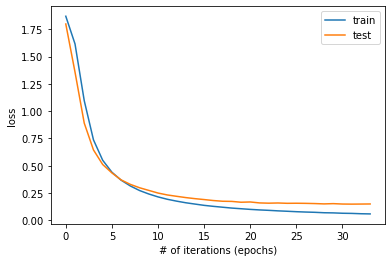

In [22]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('# of iterations (epochs)')
plt.show()

In [23]:
# testing 9 simple headlines
phrase1 = 'Pfizer receives FDA approval for its COVID-19 vaccination',
phrase2 = 'Tesla expects to deliver 350,000 cars in the next quarter, estimates revenue increased by 5%',
phrase3 = 'Intel plans to acquire Disney to expand its consumer sector',
phrase4 = 'Apple announces a share repurchase program for up to $25 million',
phrase5 = 'Microsoft ex-CEO Bill Gates says he loves China',
phrase6 = 'Elon Musk will go to the moon with his dogecoin',
phrase7 = 'Morgan Stanley analyst upgrades Tesla to Buy, raises price target to $4,000',
phrase8 = 'AMD Q4-2025 Adj. EPS $1.89 beats $0.85 estimate, sales $3.37B beat $1.33B estimate',
phrase9 = 'Notable put options activity in Gamestop',

phrase_list = [phrase1, phrase2, phrase3, phrase4, phrase5, phrase6, phrase7, phrase8, phrase9]

for phrase in phrase_list:
    X_te_seq = tokenizer.texts_to_sequences(phrase)
    X_te_pad = pad_sequences(X_te_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    prediction = model.predict(X_te_pad)
    classes = np.argmax(prediction, axis=-1)

    print(f'{phrase}: {sentiment_dict[int(classes[0])]}')

('Pfizer receives FDA approval for its COVID-19 vaccination',): corporate_action
('Tesla expects to deliver 350,000 cars in the next quarter, estimates revenue increased by 5%',): redundant_meaningless
('Intel plans to acquire Disney to expand its consumer sector',): merger_acquisition
('Apple announces a share repurchase program for up to $25 million',): corporate_action
('Microsoft ex-CEO Bill Gates says he loves China',): redundant_meaningless
('Elon Musk will go to the moon with his dogecoin',): redundant_meaningless
('Morgan Stanley analyst upgrades Tesla to Buy, raises price target to $4,000',): analyst_action
('AMD Q4-2025 Adj. EPS $1.89 beats $0.85 estimate, sales $3.37B beat $1.33B estimate',): earnings
('Notable put options activity in Gamestop',): options


In [24]:
# save model
model.save('models/manual_model.h5')

## Predicting

### Web scraping

In [25]:
# retrieve data through web scraping
base_url = 'https://finviz.com/quote.ashx?t='
ticker = 'TSLA'
url = base_url + ticker

req = Request(url=url, headers={'user-agent': 'Mozilla/5.0'})
response = urlopen(req)

html = bs(response)
news_table = html.find(id='news-table')
news_row = news_table.findAll('tr')

In [26]:
df_ticker_news = pd.DataFrame(columns=['time', 'title'])

In [27]:
for i, row in enumerate(news_row):
    a_text = row.a.text
    td_text = row.td.text
    df_ticker_news = df_ticker_news.append({'time': td_text, 'title': a_text}, ignore_index=True)

In [28]:
df_ticker_news.head()

,time,title
0,Jul-26-21 09:19PM,"Dow Jones Futures Fall As Tesla Earnings Beat, While Apple Leads 4 Tech Gian..."
1,07:48PM,PRESS DIGEST-British Business - July 27
2,07:47PM,Is Lucid Motors Stock A Buy Right Now As LCID Surges After Its Highly Antici...
3,06:58PM,"Tesla Earnings Beat But Musk Warns On Chips, Semi Delayed; FSD Subscription ..."
4,06:50PM,Teslas Earnings Came in Strong. One Thing Is Holding the Stock Back.


### Model loading

In [29]:
# load tokenizer
with open('models/manual_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# load model
model = tf.keras.models.load_model('models/manual_model.h5')

In [30]:
# declare variables for preprocessing
vocab_size = 1000
max_length = 142
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'

def preprocess_text(text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded

In [31]:
padded = preprocess_text(df_ticker_news['title'])
prediction = model.predict(padded)
prediction[:5]

array([[1.08193800e-01, 4.22160417e-01, 1.09578166e-02, 6.94175623e-03,
        3.99167240e-01, 5.05796447e-02, 1.99939846e-03],
       [7.48753082e-03, 8.61174107e-01, 1.61708158e-03, 1.54862972e-02,
        1.02531649e-01, 9.90820583e-03, 1.79523544e-03],
       [1.71265856e-04, 8.87918472e-01, 2.21456794e-04, 1.07254431e-01,
        3.31068644e-03, 2.73038400e-04, 8.50627664e-04],
       [4.05216515e-02, 7.76351750e-01, 1.19979903e-02, 4.64756750e-02,
        1.08420685e-01, 1.50591088e-02, 1.17319997e-03],
       [7.07828731e-05, 9.92805183e-01, 3.35855520e-06, 1.82682322e-03,
        2.94150691e-03, 2.32375925e-03, 2.86260984e-05]], dtype=float32)

In [32]:
# real news results
df_ticker_news['mapper'] = np.argmax(prediction, axis=-1)
df_ticker_news['type'] = df_ticker_news['mapper'].map(sentiment_dict)
print(df_ticker_news[['title', 'type']][:20])

                                                                              title                   type
0   Dow Jones Futures Fall As Tesla Earnings Beat, While Apple Leads 4 Tech Gian...  redundant_meaningless
1                                           PRESS DIGEST-British Business - July 27  redundant_meaningless
2   Is Lucid Motors Stock A Buy Right Now As LCID Surges After Its Highly Antici...  redundant_meaningless
3   Tesla Earnings Beat But Musk Warns On Chips, Semi Delayed; FSD Subscription ...  redundant_meaningless
4              Teslas Earnings Came in Strong. One Thing Is Holding the Stock Back.  redundant_meaningless
5                                Tesla Beats in Q2 as Indexes Set New Closing Highs               earnings
6          Lucid Motors CEO market debut, retail investors, and what's next for EVs  redundant_meaningless
7                               Tesla (TSLA) Q2 Earnings and Revenues Top Estimates               earnings
8                       Tesla posts r

In [33]:
df_ticker_news['type'].value_counts()

redundant_meaningless    89
analyst_action            6
earnings                  4
corporate_action          1
Name: type, dtype: int64

## Conclusion

In the 8 trials we tested, the model stopped in the range of 25 to 37 times, with an accuracy between 94.2 and 97.0%. In this particular iteration, epoch stops at 34 with an accuracy of 95.8% on the validation dataset.

Same as the rules-based model, I added early stopping to the model based on the loss function with a patience of 2, meaning the model will train 2 more times after the loss has hit the min. In this case, the model stops training after 34 times.

In predicting TSLA news, out of the 20 news headlines, it classified 4 in earnings, 15 in Redundant/Meaningless, and 1 Analyst Action. The Analyst Action identification shows inconsistency in the model. However, it is more conservative than the rules-based model because it identifies the majority of the headlines as meaningless news and only focuses on the few ones that may cause actions in the stock price movement.

### Further work

We will add more examples to the training set to improve consistency and prediction.

Similar to the rules-based model, we can try other neural network models and select other layers and add more neuron layers to further optimize the model.